# ***Introduction***

This is a quick submission for the 9th episode of Season 3 of the Kaggle playground series. This competition is a regression problem where we have to predict the strength of concrete based on the amount of different ingredients used to make it. 

After some quick EDA and hyperparameter tuning, I was able to get a top 12 position with a score (rmse) of 12.25232 on the public and 11.84610 on the private leaderboard.

![alt text](leaderboard.png)


# ***Imports***

In [2]:
%%capture
!pip install jupyter_black
!pip install kaggle
!pip install lightgbm
!pip install lofo-importance


In [3]:
import os
import time
import random
import warnings

warnings.filterwarnings("ignore")

import jupyter_black

jupyter_black.load()

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

sns.set(style="darkgrid")

import itertools
from colorama import Fore, Style

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


from lofo import LOFOImportance, Dataset, plot_importance

dataset_lofo = Dataset

import xgboost as xgb
import lightgbm as lgb


pd.options.display.max_columns = None

os.environ["KAGGLE_USERNAME"] = "davidvikstrand"
os.environ["KAGGLE_KEY"] = XXX

palette = [
    "#302c36",
    "#037d97",
    "#E4591E",
    "#C09741",
    "#EC5B6D",
    "#90A6B1",
    "#6ca957",
    "#D8E3E2",
]

bold = ["\033[1m", "\033[0m"]

grn = Style.BRIGHT + Fore.GREEN
gr = Fore.GREEN
gld = Style.BRIGHT + Fore.YELLOW
gl = Fore.YELLOW
bl = Fore.BLUE
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL
mag = Style.BRIGHT + Fore.MAGENTA

# Fore.BLACK
# Fore.RED
# Fore.GREENn
# Fore.YELLOW
# Fore.BLUE
# Fore.MAGENTA
# Fore.CYAN
# Fore.WHITE

In [5]:
# !kaggle competitions download -c playground-series-s3e9
# !mkdir -p s3e9
# !unzip playground-series-s3e9.zip -d s3e9
# !rm playground-series-s3e9.zip

Archive:  playground-series-s3e9.zip
  inflating: s3e9/sample_submission.csv  
  inflating: s3e9/test.csv           
  inflating: s3e9/train.csv          


# ***Data Overview***

<p>There Various Factors that affects the Strength of Concrete Such as  Materials Used, Age etc.<br>
Predict the Strength of the Concrete Based on the Components and Other Factors as Predictors.</p>
<p><strong>Description of Fields are as follows:-</strong></p>
<ul>
<li><strong>CementComponent</strong>:- Amount of cement is mixed</li>
<li><strong>BlastFurnaceSlag</strong>:- Amount of Blast Furnace Slag is mixed</li>
<li><strong>FlyAshComponent</strong>:- Amount of FlyAsh is mixed</li>
<li><strong>WaterComponent</strong>:- Amount of water is mixed</li>
<li><strong>SuperplasticizerComponent</strong>:- Amount of Super plasticizer is mixed</li>
<li><strong>CoarseAggregateComponent</strong>:- Amount of Coarse Aggregate is mixed</li>
<li><strong>FineAggregateComponent</strong>:- Amount of Coarse Aggregate is mixed</li>
<li><strong>AgeInDays</strong>:- How many days it was left dry</li>
<li><strong>Strength</strong>:- What was the final strength of concrete- <strong>(Target)</strong>

In [58]:
s_e = "s3e9"

train = pd.read_csv(f"{s_e}/train.csv")
test = pd.read_csv(f"{s_e}/test.csv")
ss = pd.read_csv(f"{s_e}/sample_submission.csv")
org = pd.read_csv(f"{s_e}/org.xls")

train.pop("id")
test.pop("id")

target = "Strength"

print("Training shape:", train.shape)
print("Testing shape:", test.shape)
print("Original shape:", org.shape)

org.columns = org.columns.str.strip()

seed = 420

train.head()

Training shape: (5407, 9)
Testing shape: (3605, 8)
Original shape: (1030, 9)


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [59]:
pd.DataFrame(
    {
        "train_na": train.isna().sum(),
        "test_na": test.isna().sum(),
        "org_na": org.isna().sum(),
        "nunique": train.nunique(),
        "dtypes": train.dtypes,
    }
)

,train_na,test_na,org_na,nunique,dtypes
AgeInDays,0,0.0,0,15,int64
BlastFurnaceSlag,0,0.0,0,224,float64
CementComponent,0,0.0,0,314,float64
CoarseAggregateComponent,0,0.0,0,342,float64
FineAggregateComponent,0,0.0,0,376,float64
FlyAshComponent,0,0.0,0,177,float64
Strength,0,NaN,0,843,float64
SuperplasticizerComponent,0,0.0,0,112,float64
WaterComponent,0,0.0,0,215,float64


# ***EDA***

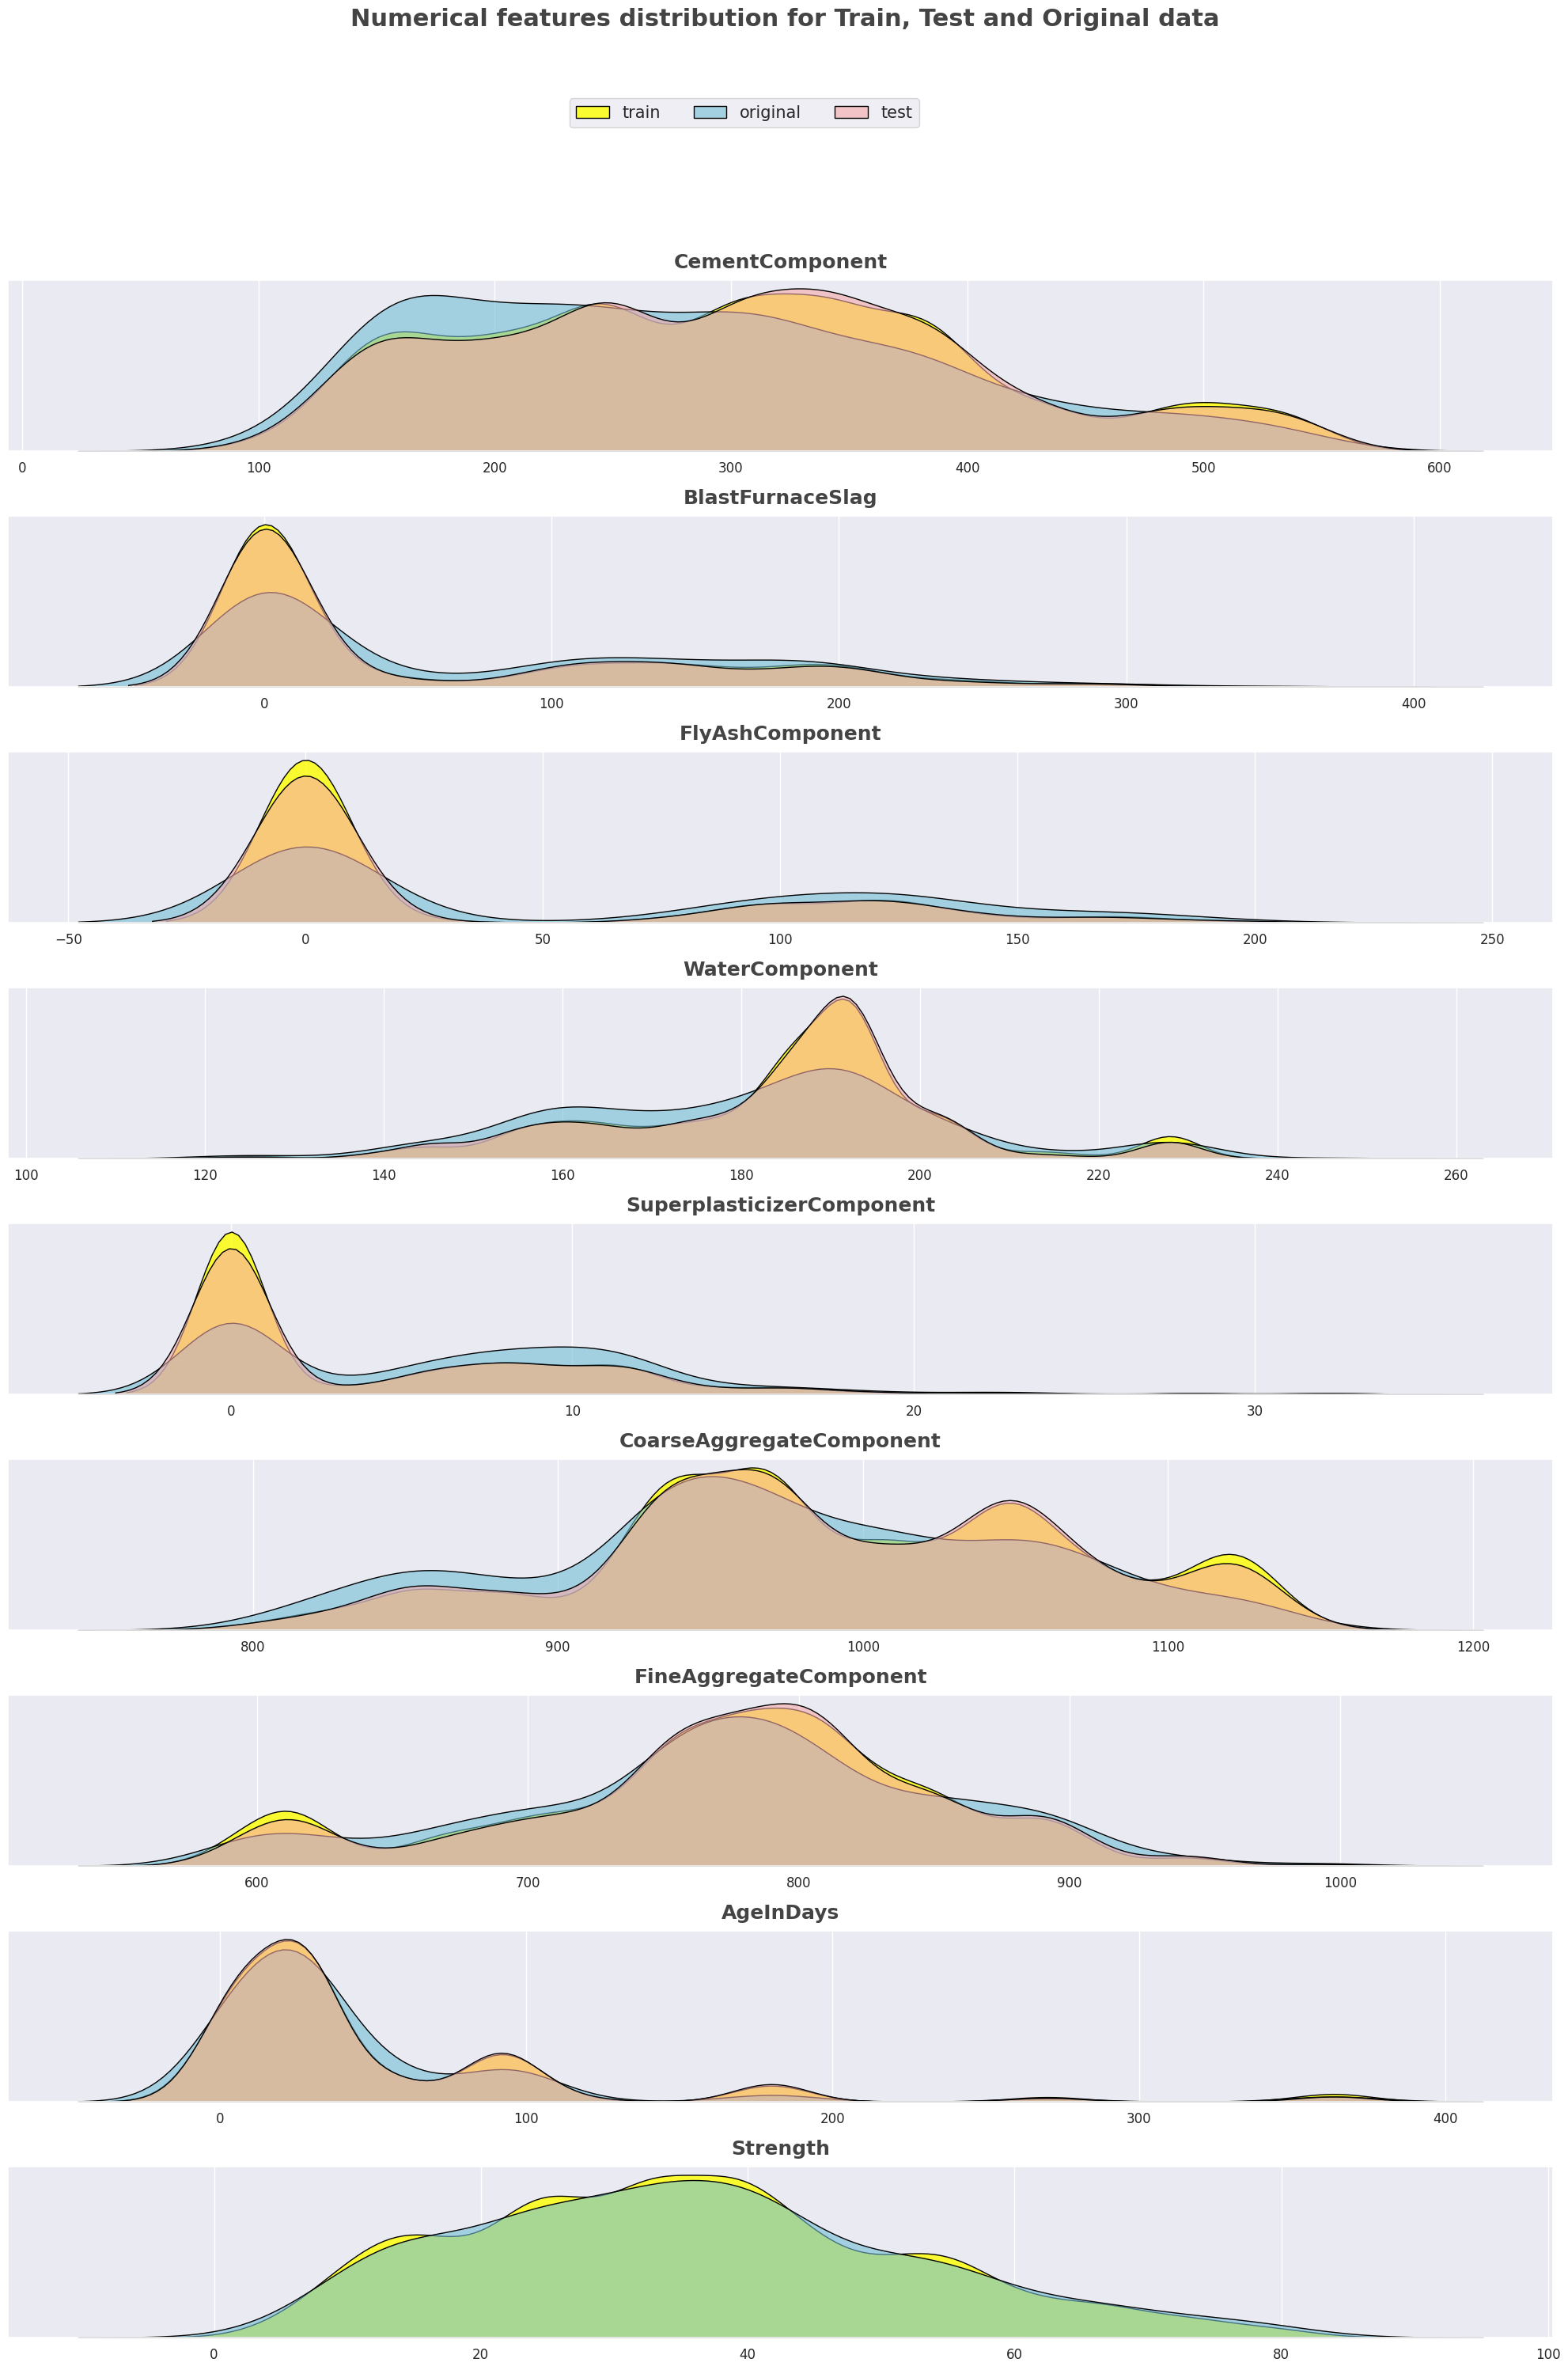

In [5]:
numeric_cols = train.select_dtypes(np.number).columns.tolist()

fig, axs = plt.subplots(
    nrows=len(numeric_cols), ncols=1, figsize=(20, len(numeric_cols) * 3)
)
axs = axs.flatten()

for i, col in enumerate(numeric_cols):
    plt.sca(axs[i])
    plt.title(col, size=18, y=1.03, fontweight="bold", color="#444444")
    a = sns.kdeplot(
        train[col],
        color="yellow",
        shade=True,
        label="train kaggle",
        alpha=0.8,
        edgecolor="black",
    )
    sns.kdeplot(
        org[col],
        color="#72bfd6",
        shade=True,
        label="train original",
        alpha=0.6,
        edgecolor="black",
    )
    if col != target:
        sns.kdeplot(
            test[col],
            color="#F5A9A9",
            shade=True,
            label="test",
            alpha=0.6,
            edgecolor="black",
        )
    plt.ylabel("")
    plt.xlabel("")
    plt.xticks(size=12)
    plt.yticks([])

fig.tight_layout()
fig.legend(
    ["train", "original", "test"],
    bbox_to_anchor=(0.59, 1.07),
    ncol=3,
    fontsize=15,
)
plt.figtext(
    0.5,
    1.1,
    "Numerical features distribution for Train, Test and Original data",
    fontweight="bold",
    size=22,
    color="#444444",
    ha="center",
)
plt.show()

**Note:**

The original data don't really match the generated data. I will not use the original data for this competition.

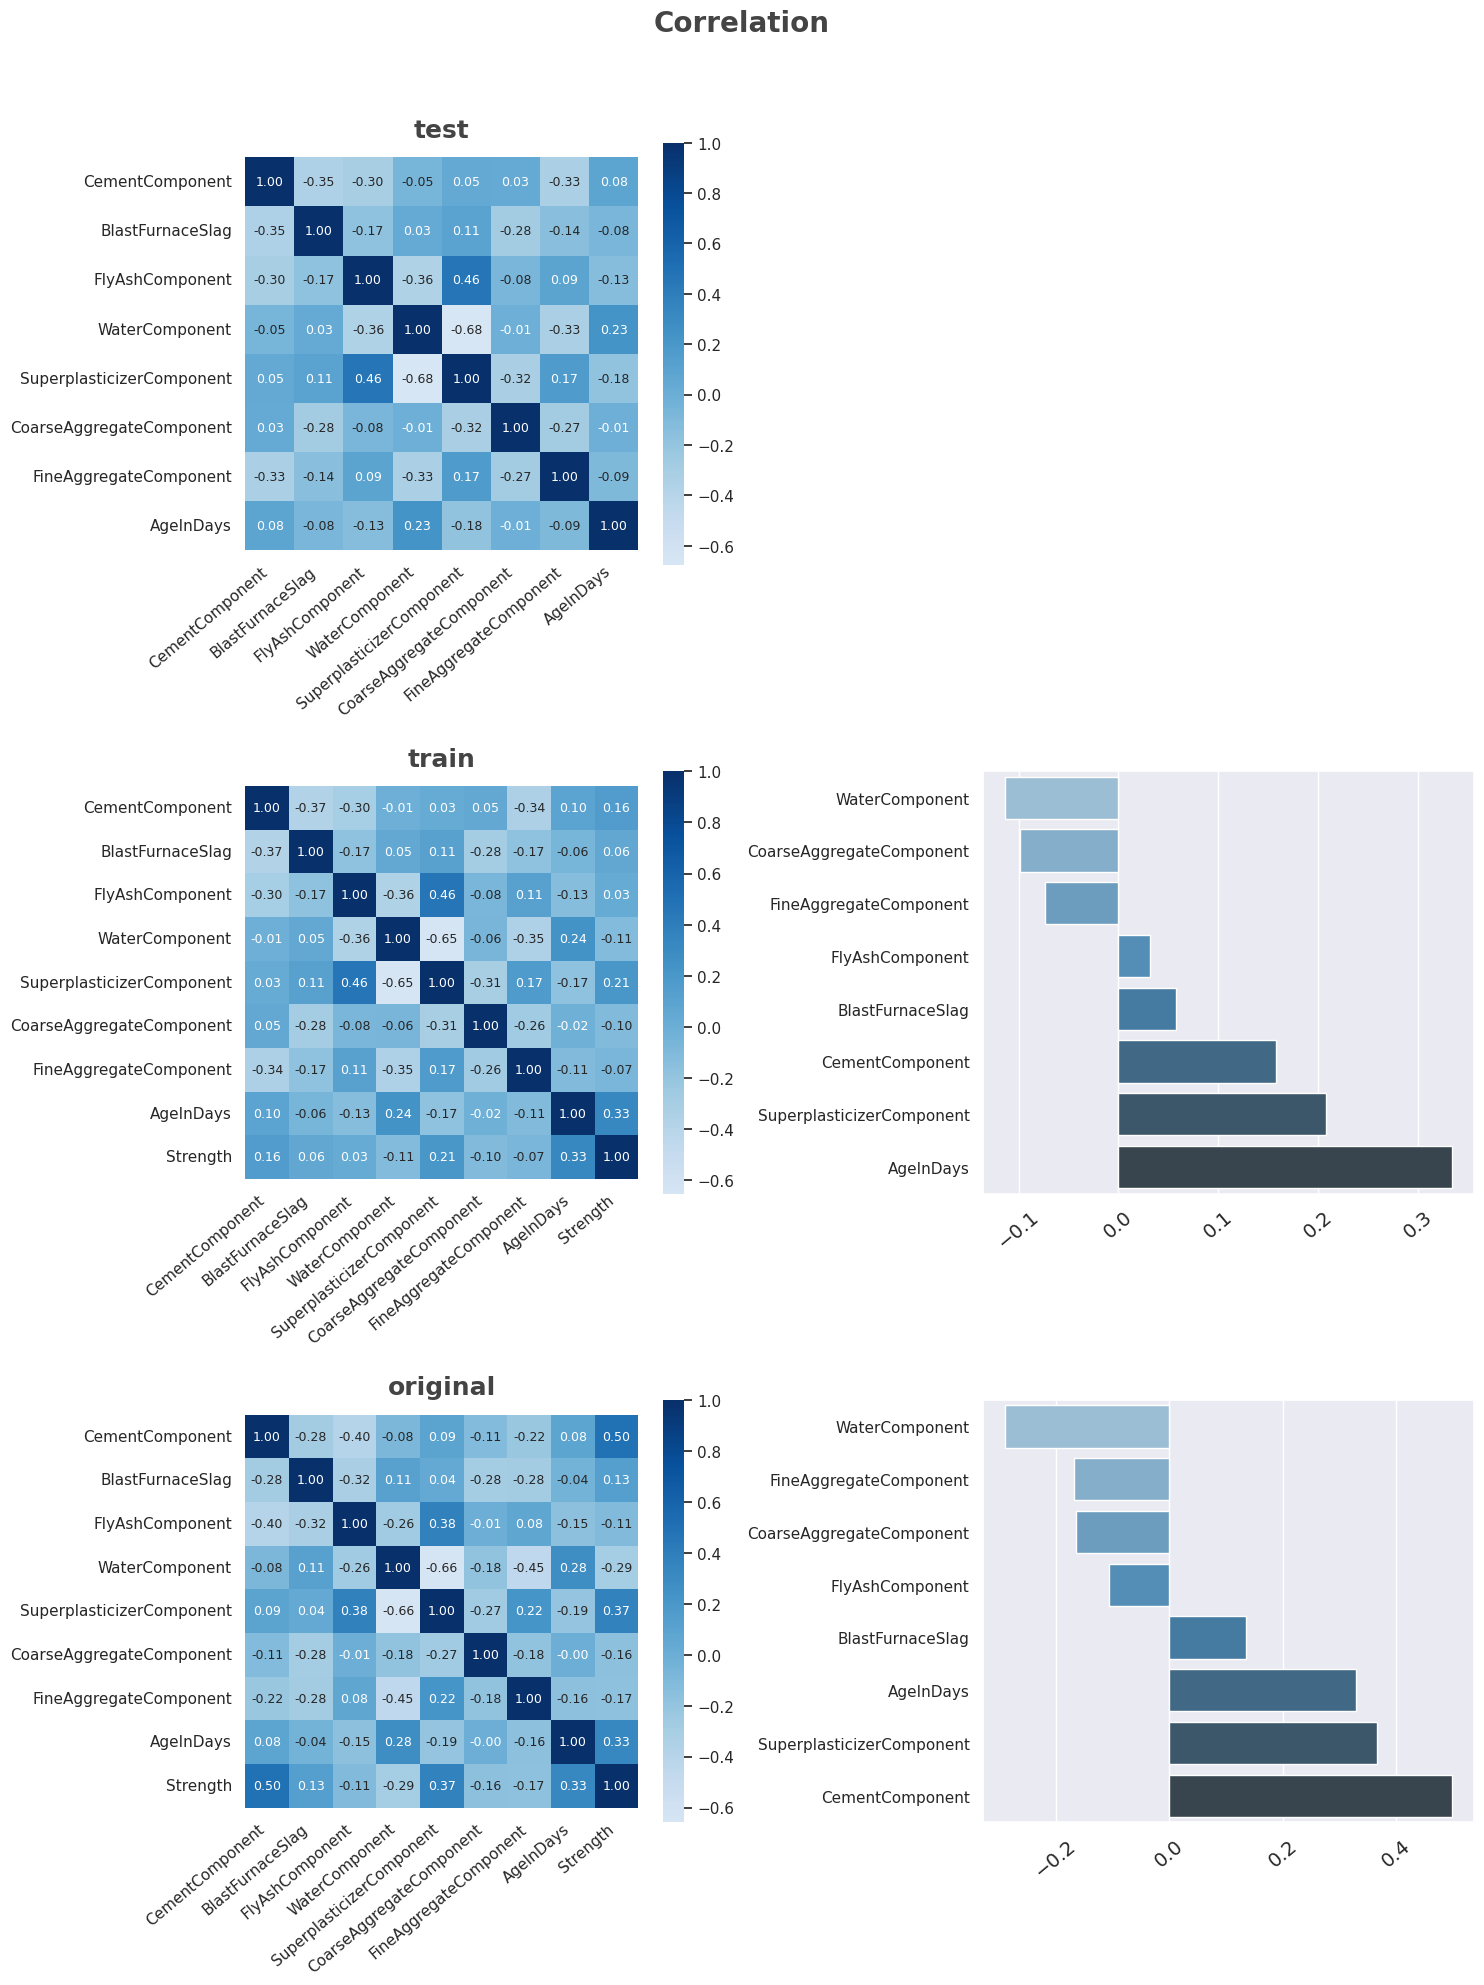

In [6]:
def plot_correlation(target=target, annot=True, df=None, names=None):
    df = df if df is not None else [train]
    fig, axs = plt.subplots(nrows=len(df), ncols=2, figsize=(15, 6.5 * len(df)))
    axs = axs.flatten()

    fig.suptitle(
        "Correlation",
        size=20,
        fontweight="bold",
        y=1.02,
        color="#444444",
    )

    for i, dataset in enumerate(df):
        if names:
            axs[i * 2].set_title(
                names[i], size=18, color="#444444", y=1.03, fontweight="bold"
            )

        sns.heatmap(
            dataset.corr(),
            annot=annot,
            cmap="Blues",
            fmt=".2f",
            annot_kws={"size": 9},
            square=True,
            center=0,
            ax=axs[i * 2],
        )
        axs[i * 2].set_xticklabels(
            axs[i * 2].get_xticklabels(), rotation=40, horizontalalignment="right"
        )

        if target not in dataset.columns:
            axs[i * 2 + 1].axis("off")
            continue
        corr_values = (
            dataset.drop([target], axis=1).corrwith(dataset[target]).sort_values()
        )
        sns.barplot(
            x=corr_values.values,
            y=corr_values.index,
            orient="h",
            ax=axs[i * 2 + 1],
            palette="Blues_d",
        )

        axs[i * 2 + 1].tick_params(axis="x", labelrotation=40, labelsize=14)

    plt.tight_layout()
    plt.show()


plot_correlation(df=[test, train, org], names=["test", "train", "original"])

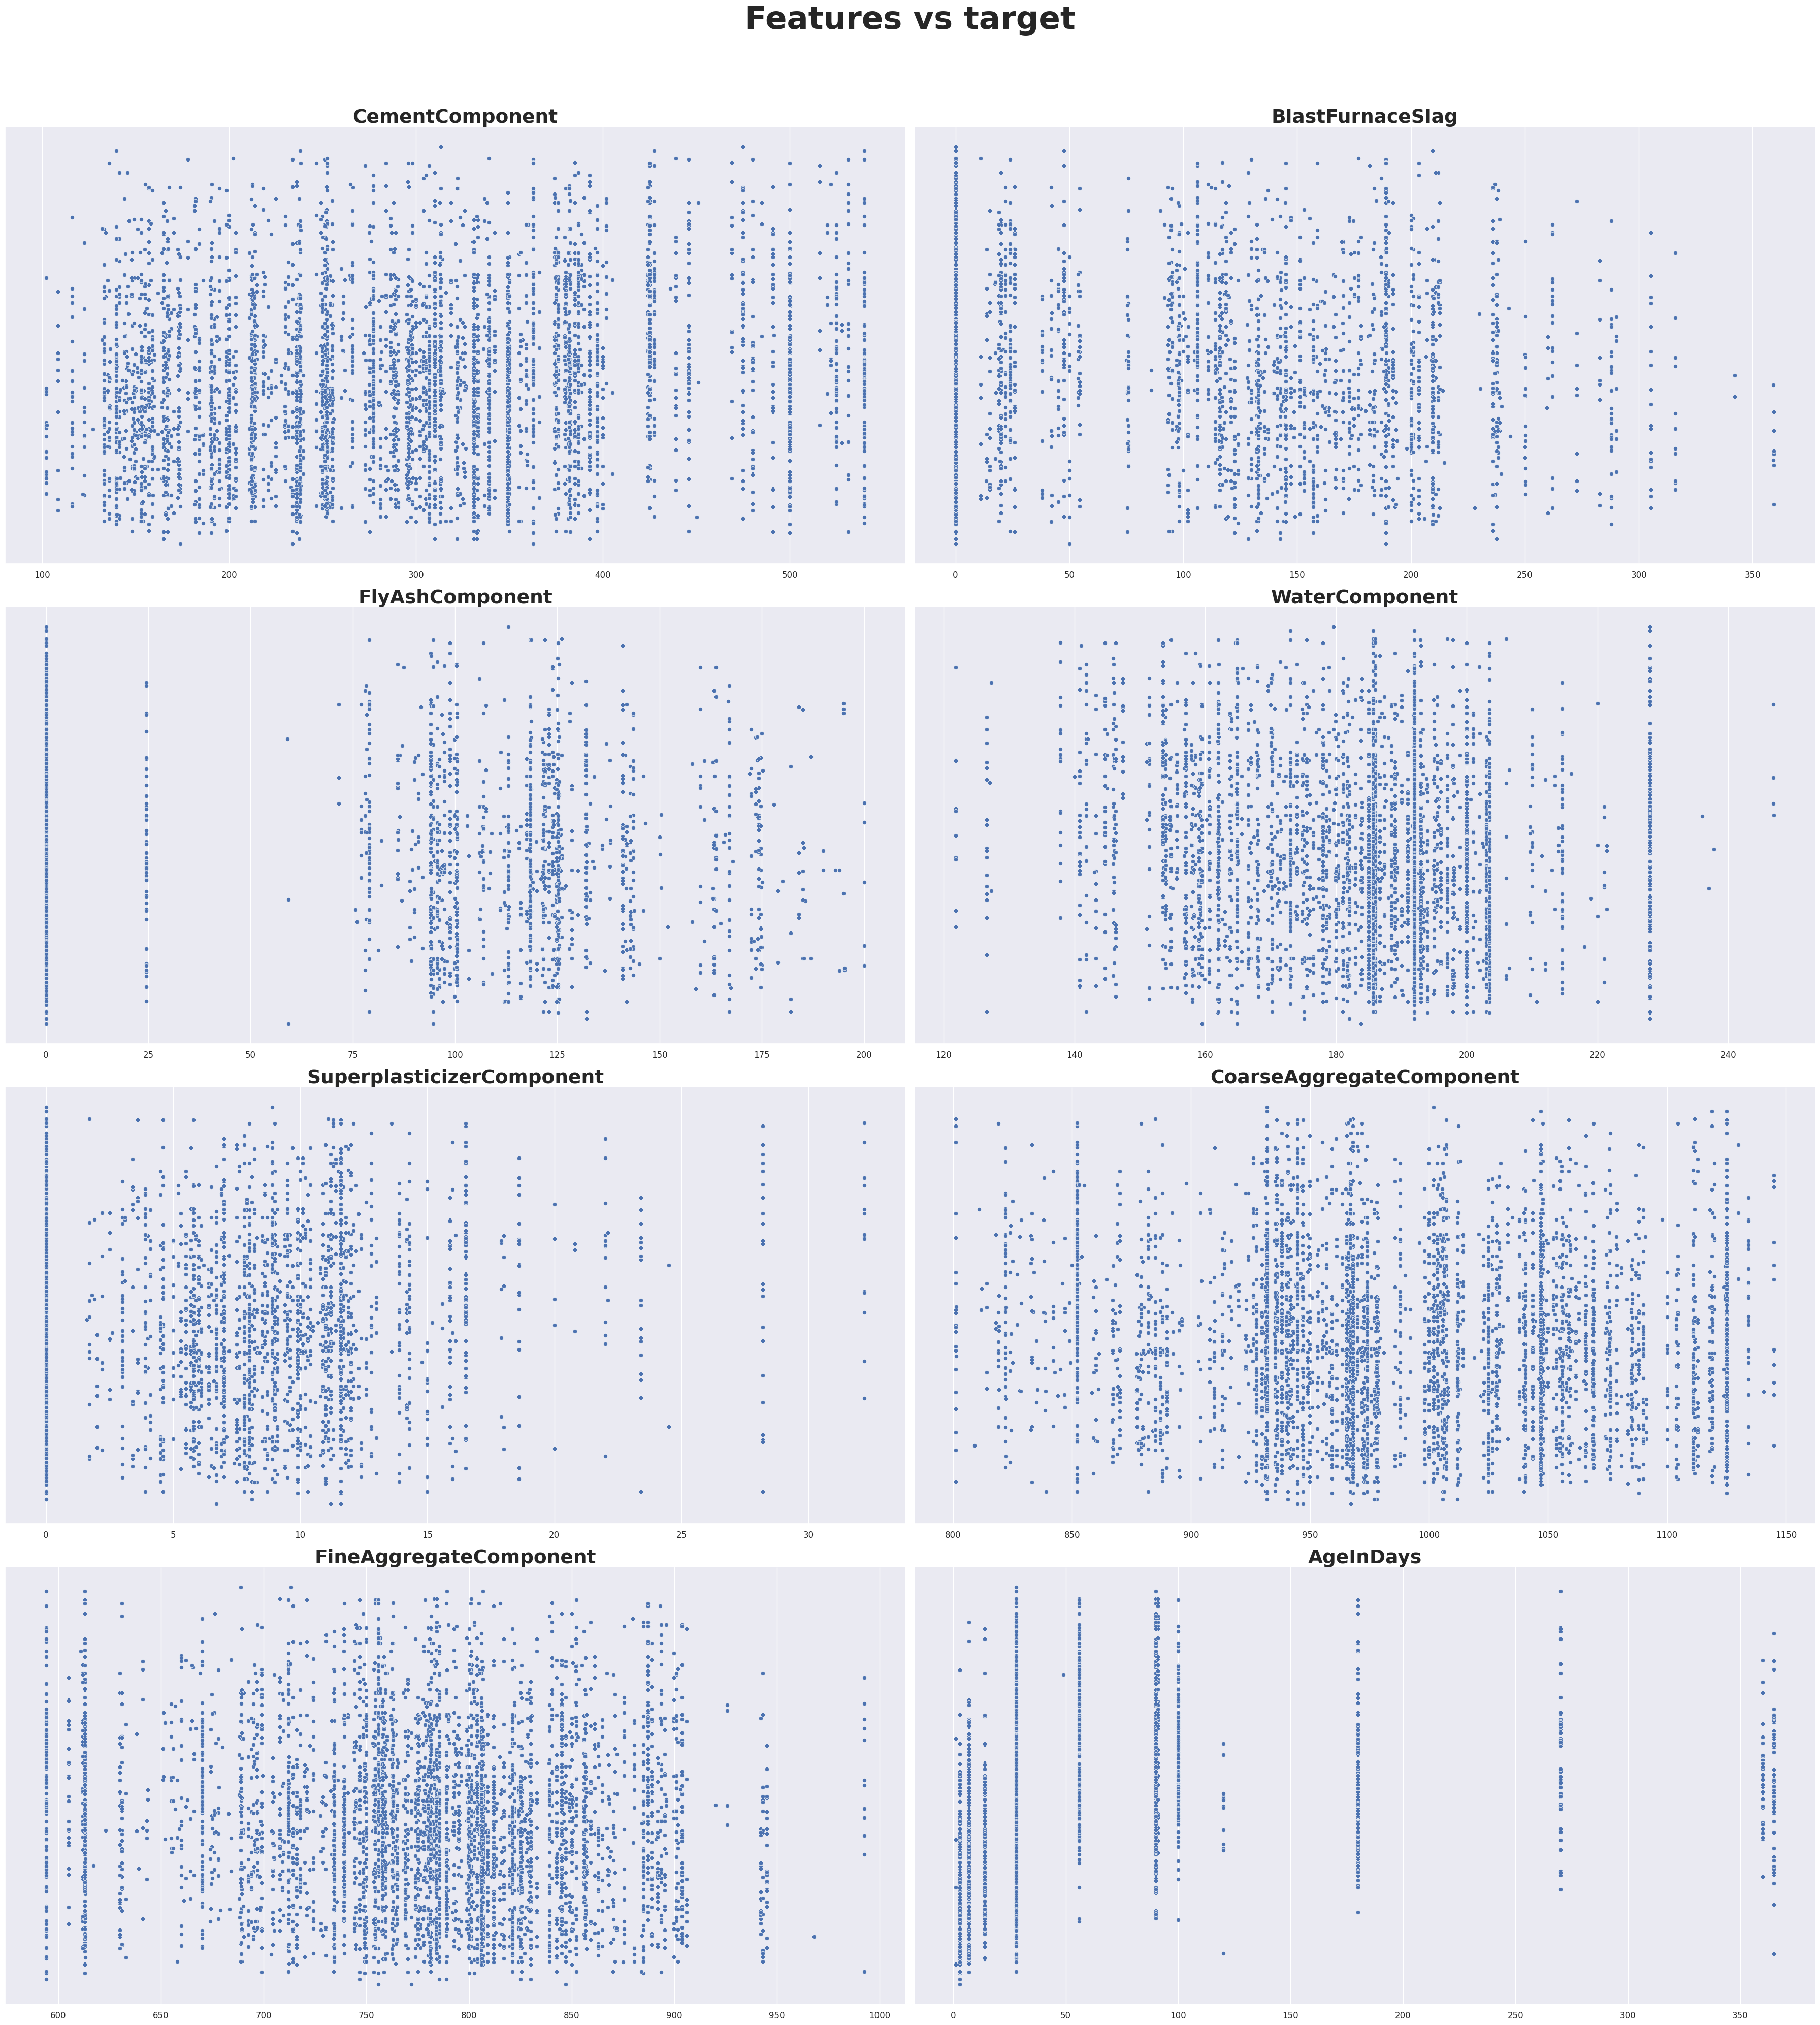

In [7]:
fig = plt.figure(figsize=(6 * 6, 25 * 2))
for idx, col in enumerate(numeric_cols[:-1]):
    ax = plt.subplot(5, 2, idx + 1)
    sns.scatterplot(data=train, y=target, x=col, legend=False)

    ax.set_ylabel("")
    ax.spines["top"].set_visible(False),
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{col}", weight="bold", fontsize=27)

    plt.ylabel("")
    plt.xlabel("")
    plt.xticks(size=12)
    plt.yticks([])


fig.suptitle(f"Features vs target\n\n\n", ha="center", fontweight="bold", fontsize=45)
plt.tight_layout()
plt.show()

**Notes:**

Really messy plots with no clear correlation between the features and the target.

# ***Feature Importance***

I will use a method called **LOFO** do get a quick overview of the feature importance.

"""

LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

If a model is not passed as an argument to LOFO Importance, it will run LightGBM as a default model.

"""

More info [here](https://github.com/aerdem4/lofo-importance)

In [95]:
default_xgb = {
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": seed,
}

In [7]:
def lofo(model=None):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)

    dataset = dataset_lofo(df=train, target=target, features=train.columns.drop(target))
    lofo_imp = LOFOImportance(
        dataset,
        cv=cv,
        scoring="neg_root_mean_squared_error",
        model=model if model else None,
    )
    importance_df = lofo_imp.get_importance()

    plot_importance(importance_df, figsize=(10, 10))

  0%|          | 0/8 [00:00<?, ?it/s]

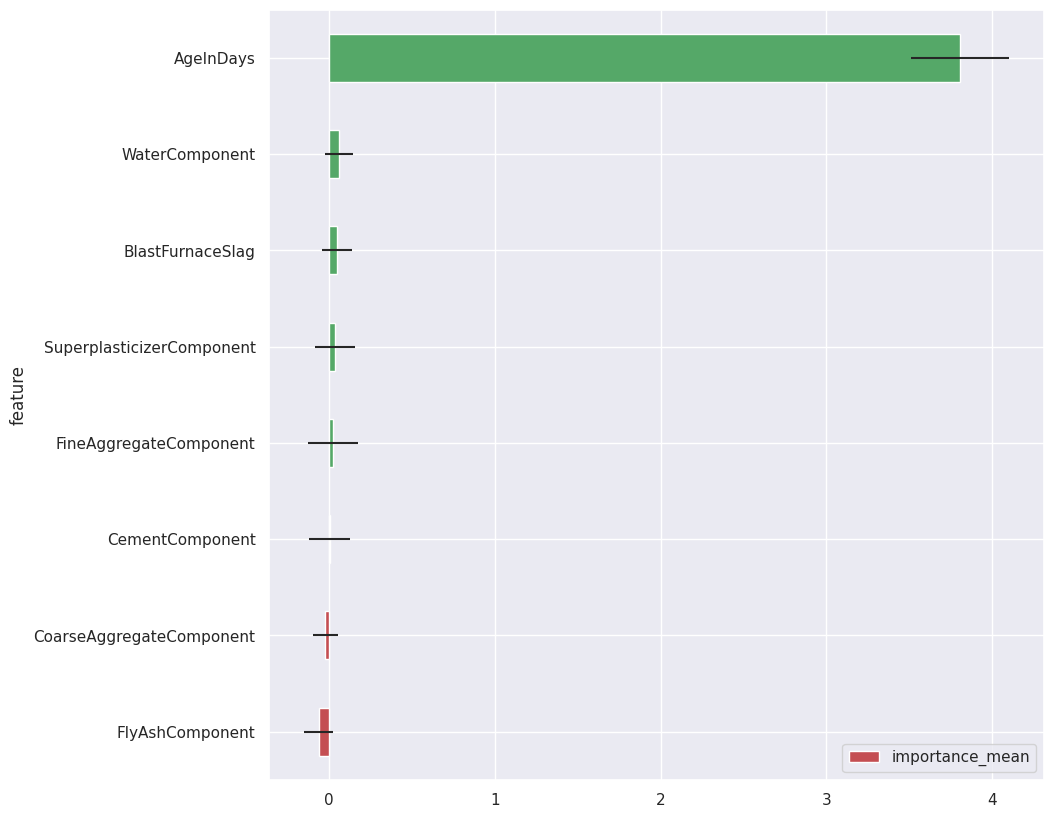

In [41]:
lofo(xgb.XGBRegressor(**default_xgb))

  0%|          | 0/8 [00:00<?, ?it/s]

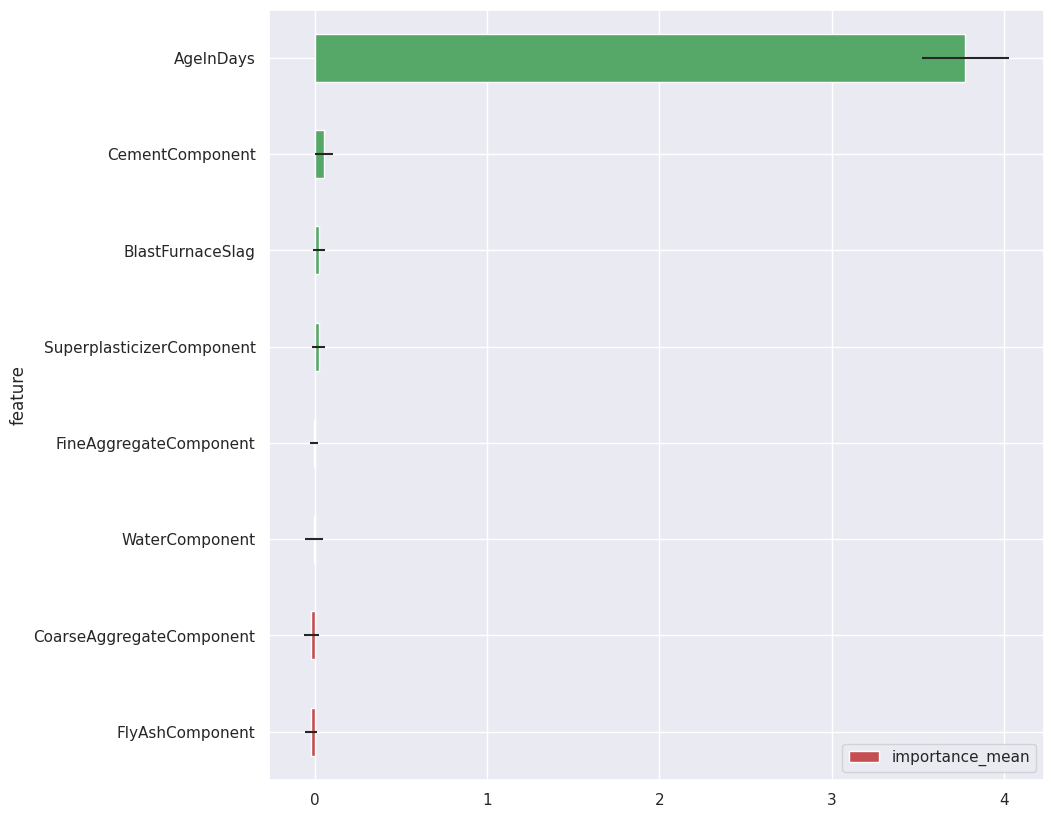

In [105]:
lofo()

I will also use **Permutation Importance** to compare the results.

In [12]:
def plot_permutation_importance(model):
    X_train, X_val, y_train, y_val = train_test_split(
        train.drop(columns=target), train[target], test_size=0.2, random_state=42
    )
    model.fit(X_train, y_train)
    perm_importance = permutation_importance(model, X_val, y_val, n_jobs=-1)

    feature_names = X_val.columns
    importance_scores = perm_importance.importances_mean

    sorted_idx = importance_scores.argsort()[::-1]
    feature_names_sorted = feature_names[sorted_idx]
    importance_scores_sorted = importance_scores[sorted_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importance_scores_sorted,
        y=feature_names_sorted,
        palette="Blues_d",
    )
    plt.xlabel("Importance Scores")
    plt.ylabel("Features")
    plt.title("Permutation Feature Importance")
    plt.show()

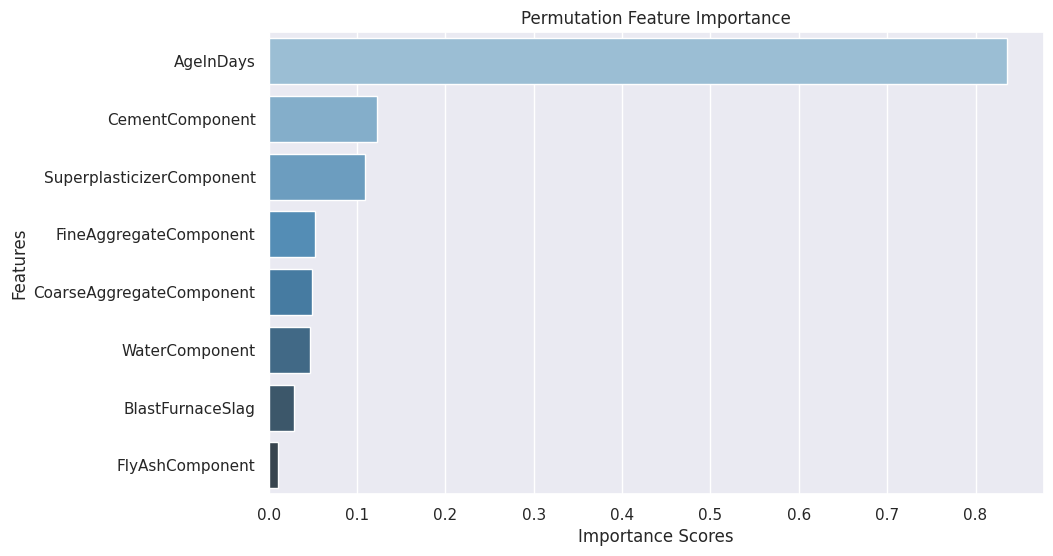

In [104]:
m = xgb.XGBRegressor(**default_xgb)
plot_permutation_importance(m)

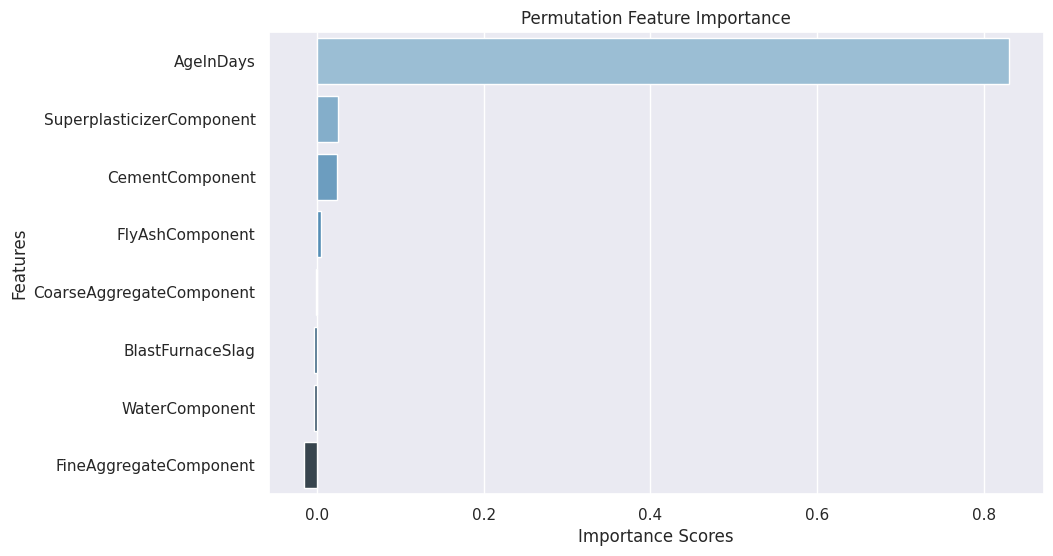

In [32]:
from sklearn.ensemble import RandomForestRegressor

m = RandomForestRegressor(n_estimators=400, random_state=420)
plot_permutation_importance(m)

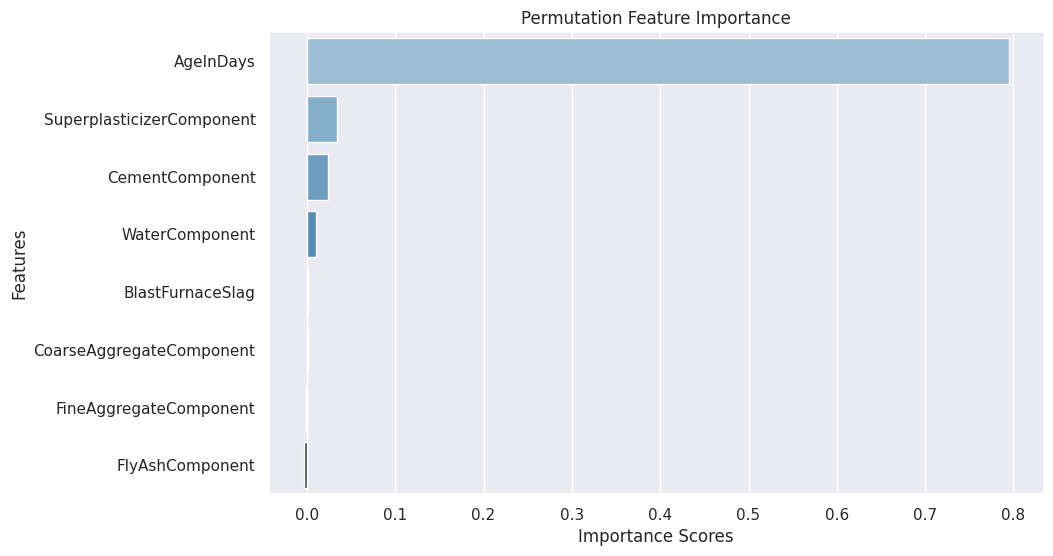

In [43]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

m = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=50,
    learning_rate=1.0,
    loss="linear",
)


plot_permutation_importance(m)

**Notes:**

We can see that AgeInDays is the most important feature. All the other features get low score with varying scores. Maybe the score will get better is we remove some nosiy features.


In [30]:
keep = [
    "BlastFurnaceSlag",
    "WaterComponent",
    "SuperplasticizerComponent",
    "AgeInDays",
    "CementComponent",
    "FineAggregateComponent",
]

train = train[keep + [target]]
test = test[keep]

After a few attempts with cv on a subset of the data, I decided to use the full data after seeing that the score was higher with the full data.

# ***Modeling***

In [60]:
X = train.copy()
y = X.pop(target)

folds = 10
metric = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))

In [12]:
def plot_feature_importance(feat_imp, m, i):
    feat_imp["avg_imp"] = feat_imp[feat_imp.columns[1:]].mean(axis=1)
    feat_imp = feat_imp.sort_values("avg_imp", ascending=False)

    plt.figure(figsize=(20, 10))
    plt.title(
        f"{m} params {i}\n\nFeature importances",
        size=25,
        y=1.02,
        x=0.4,
        fontweight="bold",
        color="#444444",
    )

    sns.barplot(data=feat_imp, x="avg_imp", y="feature", palette="Blues_d")
    plt.xlabel("")
    plt.xticks([])
    plt.ylabel("")

# ***XGB***

Heres a custom hyperparameter tuning method I made. It uses random search for a subset of the parameters and keeps the parameters if it improves the score, before moving on to the next parameter subset.

In [97]:
def random_seq_search(
    ob,
    params_dict,
    n_folds=5,
    n_trials=50,
    stopping_rounds=50,
    seed_mod=3,
    set_leaves=False
):
    best_params, best_score = {}, np.inf if ob == "minimize" else 0
    compare_f = {"minimize": lambda x, y: x < y, "maximize": lambda x, y: x > y}[ob]

    for i, p in params_dict.items():
        print(*p.keys())
        used_params, temp_best_params, best_trial = [], {}, None

        for j in range({}.get(i, n_trials)):
            (v1, v2), (k1, k2) = p.values(), p.keys()
            p1, p2 = random.choice(v1), random.choice(v2)
            params = {k1: p1, k2: p2}

            for _ in range(1000):
                if params not in used_params:
                    break
                p1, p2 = random.choice(v1), random.choice(v2)
                params = {k1: p1, k2: p2}
            else:
                print("Search space exhausted")
                break
            used_params.append(params)
            
            if set_leaves and i == 0:
                params["num_leaves"] = 2 ** params["max_depth"] + 1

            cv_score, new_best = objective(params, best_params), 0
            if compare_f(cv_score, best_score):
                temp_best_params = {**params, **best_params}
                best_score = cv_score
                best_trial, new_best = j + 1, 1

            c0, c1, c2, c3 = (mag, gld, blu, grn) if new_best else (res, gl, bl, gr)

            print(
                f"{c0}{j+1}{res}: {c1}{params}{res}, {c2}rmse: {cv_score}{res}",
                f"| {c3}Best trail: {best_trial}, Best rmse: {best_score}{res}",
            )

        best_params = {**temp_best_params, **best_params}
        del used_params

    print(
        f"\n{bold[0]}Final rmse:{res} {gr}{best_score}{res}",
        f"\n{bold[0]}Final params: {res}{gr}{best_params}{res}",
    )
    return best_params

In [43]:
params_dict = {
    1: {
        "max_depth": list(range(3, 8)),
        "learning_rate": np.arange(0.01, 0.055, 0.005),
    },
    2: {
        "colsample_bytree": np.arange(0.3, 1.1, 0.1),
        "subsample": np.arange(0.3, 1.1, 0.1),
    },
    3: {
        "min_child_weight": range(1, 15),
        "gamma": np.logspace(-4, 1, 6),
    },
    4: {
        "lambda": np.logspace(-4, 1, 6),
        "alpha": np.logspace(-4, 1, 6),
    },
    5: {
        "colsample_bylevel": np.arange(0.3, 1.1, 0.1),
        "colsample_bynode": np.arange(0.3, 1.1, 0.1),
    },
}

dtrain = xgb.DMatrix(X, y, enable_categorical=True)


def objective(params, best_params, n_folds, stopping, seed_mod):
    cv_results = xgb.cv(
        params={**params, **default_xgb, **best_params},
        dtrain=dtrain,
        num_boost_round=10_000,
        nfold=n_folds,
        metrics="rmse",
        early_stopping_rounds=stopping,
        shuffle=True,
        stratified=False,
        seed=seed * seed_mod,
    )

    return cv_results["test-rmse-mean"].iloc[-1]


seq_params = {
    "n_folds": 5,
    "n_trials": 70,
    "stopping_rounds": 100,
    "seed_mod": 3,
    "ob": "minimize",
    "params_dict": params_dict,
}

xgb_params = random_seq_search(**seq_params)

max_depth learning_rate
1: {'max_depth': 4, 'learning_rate': 0.015}, rmse: 12.172944351822121 | Best trail: 1, Best rmse: 12.172944351822121
2: {'max_depth': 5, 'learning_rate': 0.049999999999999996}, rmse: 12.1910951510778 | Best trail: 1, Best rmse: 12.172944351822121
3: {'max_depth': 4, 'learning_rate': 0.045}, rmse: 12.172984575828576 | Best trail: 1, Best rmse: 12.172944351822121
4: {'max_depth': 5, 'learning_rate': 0.01}, rmse: 12.183209243141926 | Best trail: 1, Best rmse: 12.172944351822121
5: {'max_depth': 6, 'learning_rate': 0.019999999999999997}, rmse: 12.26035406607052 | Best trail: 1, Best rmse: 12.172944351822121
6: {'max_depth': 3, 'learning_rate': 0.039999999999999994}, rmse: 12.15720966146308 | Best trail: 6, Best rmse: 12.15720966146308
7: {'max_depth': 3, 'learning_rate': 0.049999999999999996}, rmse: 12.145711511859686 | Best trail: 7, Best rmse: 12.145711511859686
8: {'max_depth': 7, 'learning_rate': 0.039999999999999994}, rmse: 12.339692633727413 | Best trail: 7, B

In [74]:
xgb_ran_search = {
    **default_xgb,
    "colsample_bylevel": 1.0000000000000002,
    "colsample_bynode": 0.8000000000000003,
    "lambda": 10.0,
    "alpha": 1.0,
    "min_child_weight": 8,
    "gamma": 10.0,
    "colsample_bytree": 0.4,
    "subsample": 0.5,
    "max_depth": 3,
    "learning_rate": 0.049999999999999996,
}


xgb_params = (xgb_ran_search,)

Lets perform a CV with these new parameters and also let a model make predictions on the test set for each fold.

Training with {'tree_method': 'gpu_hist', 'predictor': 'gpu_predictor', 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 420, 'colsample_bylevel': 1.0000000000000002, 'colsample_bynode': 0.8000000000000003, 'lambda': 10.0, 'alpha': 1.0, 'min_child_weight': 8, 'gamma': 10.0, 'colsample_bytree': 0.4, 'subsample': 0.5, 'max_depth': 3, 'learning_rate': 0.049999999999999996}

--- FOLD 1 ---
--- Root Mean Squared Log Error: 12.498848 | best iteration: 295 ---

--- FOLD 2 ---
--- Root Mean Squared Log Error: 10.948783 | best iteration: 308 ---

--- FOLD 3 ---
--- Root Mean Squared Log Error: 12.489377 | best iteration: 533 ---

--- FOLD 4 ---
--- Root Mean Squared Log Error: 11.651218 | best iteration: 499 ---

--- FOLD 5 ---
--- Root Mean Squared Log Error: 11.718733 | best iteration: 1079 ---

--- FOLD 6 ---
--- Root Mean Squared Log Error: 11.544587 | best iteration: 240 ---

--- FOLD 7 ---
--- Root Mean Squared Log Error: 12.963343 | best iteration: 202 ---

--- FOLD 8 ---


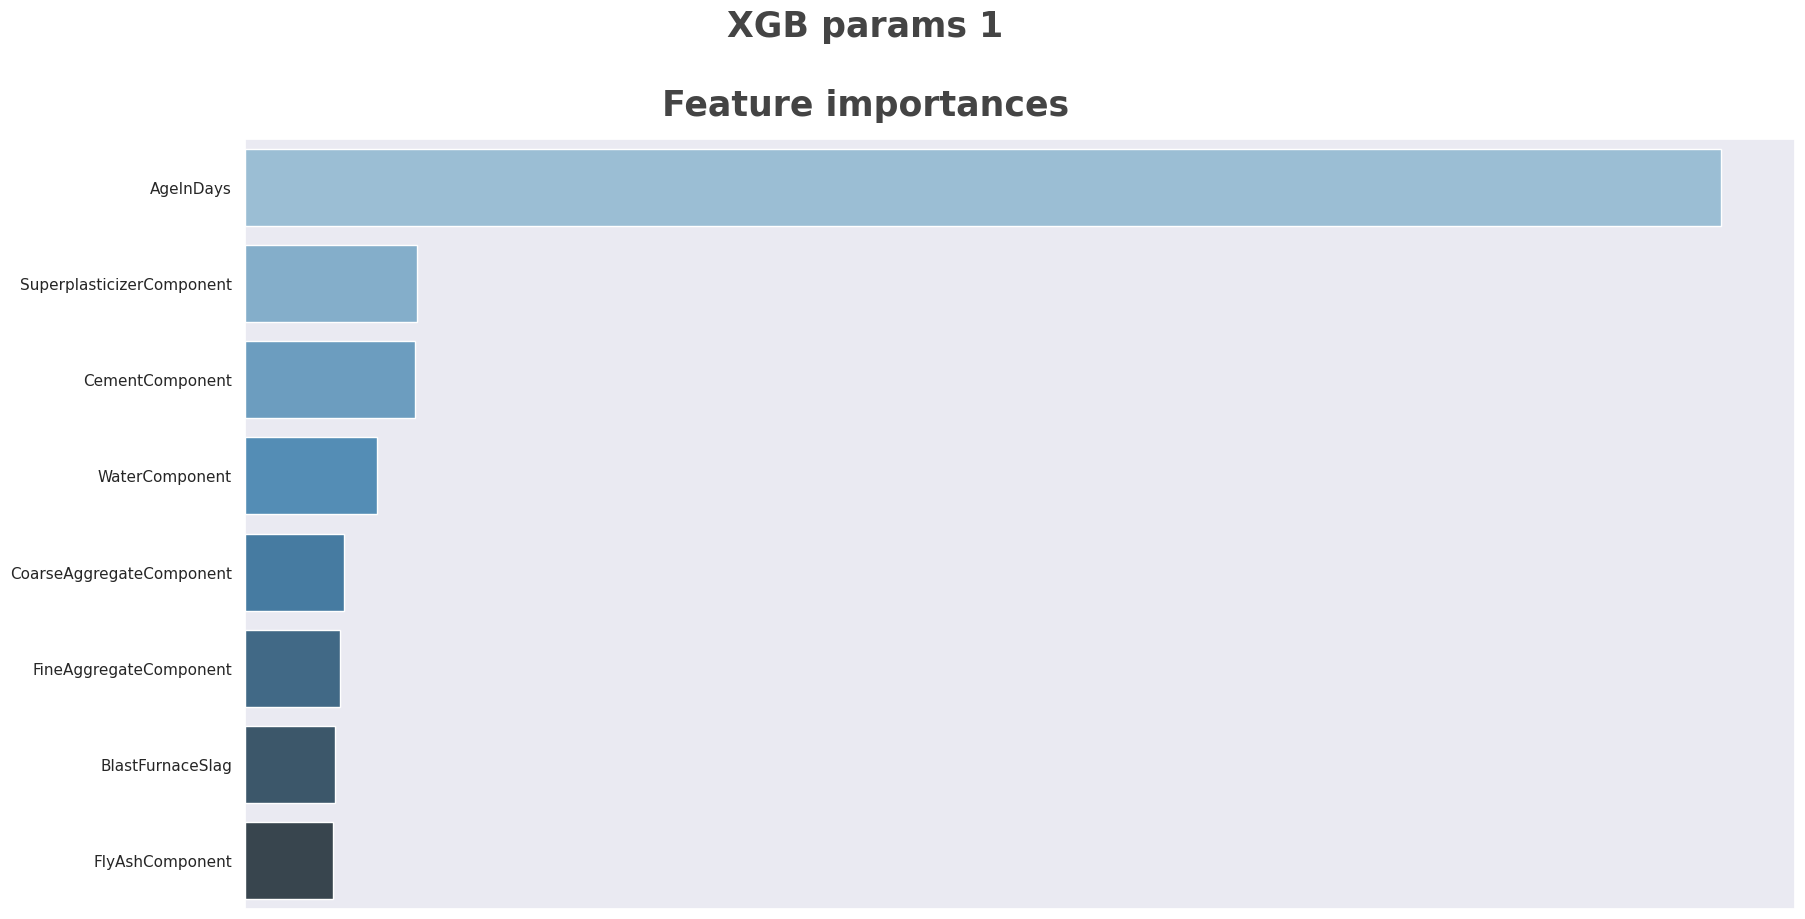

In [62]:
m = "XGB"
xgb_preds = []
seed_mod = 1

for i, params in enumerate(xgb_params, 1):
    print(f"{bold[0]}Training with {params}{res}")
    start = time.time()

    feat_imp = pd.DataFrame({"feature": X.columns})
    predictions, oof_xgb, scores_xgb = np.zeros(len(test)), np.zeros(len(X)), []

    cv = KFold(n_splits=folds, shuffle=True, random_state=seed * i * seed_mod)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        print(f"\n--- {gld}FOLD {fold}{res} ---")

        dtrain = xgb.DMatrix(
            X.iloc[train_idx],
            y.iloc[train_idx],
            enable_categorical=True,
        )

        dvalid = xgb.DMatrix(
            X.iloc[val_idx], (y_val := y.iloc[val_idx]), enable_categorical=True
        )

        watchlist = [(dtrain, "train"), (dvalid, "eval")]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=10_000,
            evals=watchlist,
            verbose_eval=False,
            callbacks=[
                xgb.callback.EarlyStopping(
                    rounds=200, data_name="eval", maximize=False, save_best=True
                )
            ],
        )

        val_preds = model.predict(dvalid)
        oof_xgb[val_idx] = val_preds

        val_score = metric(y_val, val_preds)
        scores_xgb.append(val_score)

        predictions += model.predict(xgb.DMatrix(test, enable_categorical=True)) / folds

        print(
            "--- Root Mean Squared Log Error:",
            f"{bold[0]}{round(val_score, 6)}{bold[1]}",
            f"| best iteration: {bold[0]}{model.best_ntree_limit}{bold[1]} ---",
        )

        fi = model.get_score(importance_type="gain")
        fi = pd.DataFrame({"feature": fi.keys(), f"importance_{fold}": fi.values()})
        feat_imp = feat_imp.merge(fi, on="feature", how="left").fillna(0)

    print(
        f"\n{'*' * 45}",
        f"\n{gld}Root Mean Squared Log Error:{res} ",
        f"{grn}{round(metric(y, oof_xgb), 6)}{res}",
        f"\n{gld}Training time (mins):{res}        ",
        f"{grn}{np.round((time.time() - start) / 60, 2)}{res}",
        f"\n{'*' * 45}\n",
    )

    plot_feature_importance(feat_imp, m, i)
    xgb_preds.append(predictions.copy())

In [67]:
print(f"{gld}xgb_ran_search:{res} {grn}{round(metric(y, oof_xgb), 6)}{res}")

xgb_ran_search: 12.056574


# ***LGB***

I tried to use the same method as XGB but it didn't work as well and ended up not using it.

In [66]:
default_lgb = {
    "seed": seed,
    "device": "cpu",
    "n_jobs": -1,
    "objective": "regression",
    "metric": "rmse",
    "verbose": -1,
}

In [68]:
params_dict = {
    0: {
        "max_depth": list(range(3, 7)),
        "learning_rate": np.arange(0.01, 0.055, 0.005),
    },
    2: {
        "colsample_bytree": np.arange(0.4, 1.1, 0.1),
        "subsample": np.arange(0.4, 1.1, 0.1),
    },
    1: {
        "min_split_gain": np.logspace(-5, -1, 5),
        "min_child_samples": list(range(20, 31)),
    },
    3: {
        "lambda_l1": np.logspace(-4, 1, 6),
        "lambda_l2": np.logspace(-4, 1, 6),
    },
    4: {
        "bagging_freq": list(range(1, 11)),
        "colsample_bynode": np.arange(0.4, 1.1, 0.1),
    },
}

lgb_train = lgb.Dataset(X, y)

def objective(params, best_params, n_folds, stopping, seed_mod):
    cv_results = lgb.cv(
        params={**params, **default_lgb, **best_params},
        train_set=lgb_train,
        num_boost_round=10_000,
        nfold=n_folds,
        metrics="rmse",
        early_stopping_rounds=stopping,
        stratified=False,
        shuffle=True,
        seed=seed*seed_mod,
    )

    return cv_results["rmse-mean"][-1]


seq_params = {
    "n_folds": 5,
    "n_trials": 70,
    "stopping_rounds": 100,
    "ob": "minimize",
    "params_dict": params_dict,
    "set_leaves" : True
}

lgb_params = random_seq_search(**seq_params)

max_depth learning_rate
1: {'max_depth': 4, 'learning_rate': 0.039999999999999994, 'num_leaves': 17}, rmse: 12.12177949491996 | Best trail: 1, Best rmse: 12.12177949491996
2: {'max_depth': 3, 'learning_rate': 0.015, 'num_leaves': 9}, rmse: 12.119278422547993 | Best trail: 2, Best rmse: 12.119278422547993
3: {'max_depth': 6, 'learning_rate': 0.024999999999999998, 'num_leaves': 65}, rmse: 12.189677227376304 | Best trail: 2, Best rmse: 12.119278422547993
4: {'max_depth': 3, 'learning_rate': 0.03, 'num_leaves': 9}, rmse: 12.119758258250645 | Best trail: 2, Best rmse: 12.119278422547993
5: {'max_depth': 5, 'learning_rate': 0.049999999999999996, 'num_leaves': 33}, rmse: 12.150541728423462 | Best trail: 2, Best rmse: 12.119278422547993
6: {'max_depth': 6, 'learning_rate': 0.01, 'num_leaves': 65}, rmse: 12.18748302848728 | Best trail: 2, Best rmse: 12.119278422547993
7: {'max_depth': 3, 'learning_rate': 0.039999999999999994, 'num_leaves': 9}, rmse: 12.115339644018539 | Best trail: 7, Best rmse

In [69]:
print(
    f"\n{bold[0]}Final rmse:{res} {gr}{best_score}{res}",
    f"\n{bold[0]}Final params: {res}{gr}{best_params}{res}",
)


Final rmse: 12.092780130040618 
Final params: {'bagging_freq': 6, 'colsample_bynode': 0.4, 'lambda_l1': 0.001, 'lambda_l2': 10.0, 'min_split_gain': 0.01, 'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.039999999999999994, 'num_leaves': 9}


In [70]:

lgb_ran_search = {
    **default_lgb,
    "bagging_freq": 6,
    "colsample_bynode": 0.4,
    "lambda_l1": 0.001,
    "lambda_l2": 10.0,
    "min_split_gain": 0.01,
    "min_child_samples": 25,
    "max_depth": 3,
    "learning_rate": 0.039999999999999994,
    "num_leaves": 9,
}


lgb_params = (lgb_ran_search,)

Training with {'seed': 420, 'device': 'cpu', 'n_jobs': -1, 'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'bagging_freq': 6, 'colsample_bynode': 0.4, 'lambda_l1': 0.001, 'lambda_l2': 10.0, 'min_split_gain': 0.01, 'min_child_samples': 25, 'max_depth': 3, 'learning_rate': 0.039999999999999994, 'num_leaves': 9}

--- FOLD 1 ---
--- Root Mean Squared Log Error: 12.6515 | best iteration: 99 ---

--- FOLD 2 ---
--- Root Mean Squared Log Error: 11.375534 | best iteration: 92 ---

--- FOLD 3 ---
--- Root Mean Squared Log Error: 12.774381 | best iteration: 132 ---

--- FOLD 4 ---
--- Root Mean Squared Log Error: 11.804097 | best iteration: 157 ---

--- FOLD 5 ---
--- Root Mean Squared Log Error: 11.814981 | best iteration: 125 ---

--- FOLD 6 ---
--- Root Mean Squared Log Error: 11.578905 | best iteration: 134 ---

--- FOLD 7 ---
--- Root Mean Squared Log Error: 13.292729 | best iteration: 104 ---

--- FOLD 8 ---
--- Root Mean Squared Log Error: 11.761541 | best iteration: 172 ---



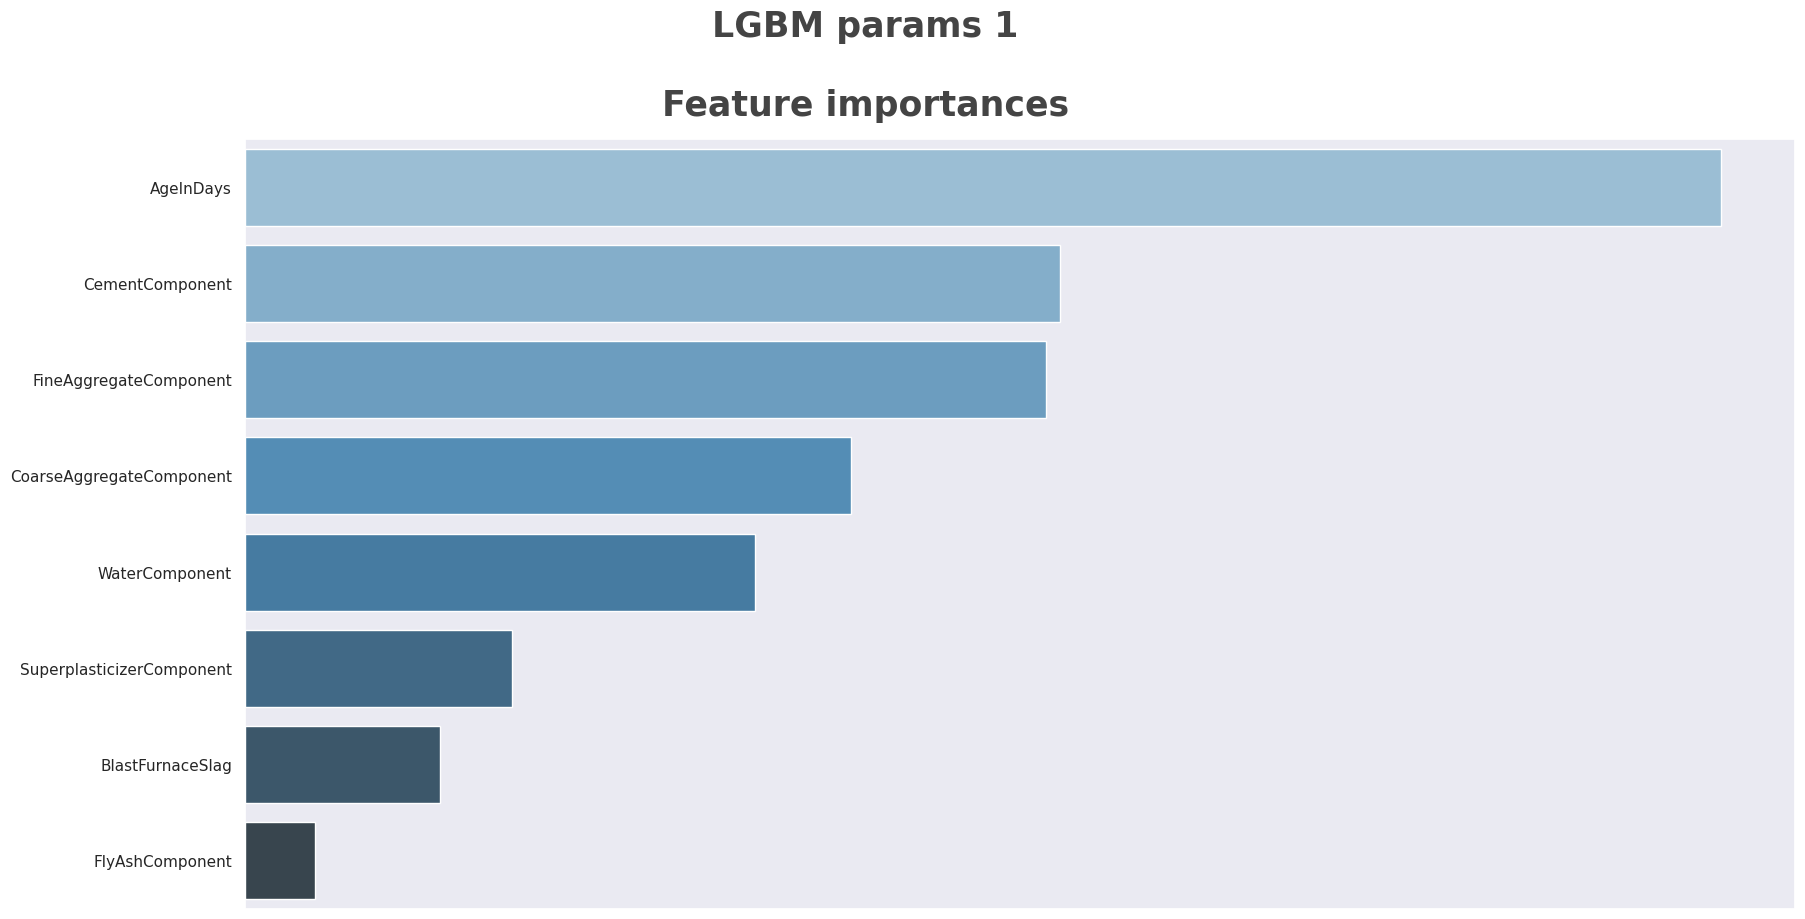

In [72]:
m = "LGBM"
lgb_preds = []
lgb_preds_cal = []

for i, params in enumerate(lgb_params, 1):
    print(f"{bold[0]}Training with {params}{res}")
    start = time.time()

    feat_imp = pd.DataFrame({"feature": X.columns})
    predictions, oof_lgb, scores_lgb = np.zeros(len(test)), np.zeros(len(X)), []

    cv = KFold(n_splits=folds, random_state=seed * i, shuffle=True)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\n--- {gld}FOLD {fold +1}{res} ---")

        lgb_train = lgb.Dataset(
            data=X.iloc[train_idx],
            label=y.iloc[train_idx],
            categorical_feature=test.columns.tolist(),
        )

        lgb_valid = lgb.Dataset(
            data=(X_val := X.iloc[val_idx]),
            label=(y_val := y.iloc[val_idx]),
            reference=lgb_train,
        )

        model = lgb.train(
            params=params,
            train_set=lgb_train,
            num_boost_round=10_000,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=["train", "val"],
            verbose_eval=False,
            categorical_feature=test.columns.tolist(),
            callbacks=[
                lgb.log_evaluation(2000),
                lgb.early_stopping(200, verbose=False),
            ],
        )

        feat_imp[f"fold_{fold + 1}"] = model.feature_importance()
        best_it = model.best_iteration

        val_preds = model.predict(X_val, num_iteration=best_it)
        oof_lgb[val_idx] = val_preds

        val_score = metric(y_val, val_preds)
        scores_lgb.append(val_score)

        predictions += model.predict(test, num_iteration=best_it) / folds

        print(
            "--- Root Mean Squared Log Error:",
            f"{bold[0]}{round(val_score, 6)}{bold[1]}",
            f"| best iteration: {bold[0]}{best_it}{bold[1]} ---",
        )

    print(
        f"\n{'*' * 45}",
        f"\n{gld}Root mean Squared Log Error:{res} ",
        f"{grn}{round(metric(y, oof_lgb), 6)}{res}",
        f"\n{gld}Training time (mins):{res}        ",
        f"{grn}{np.round((time.time() - start) / 60, 2)}{res}",
        f"\n{'*' * 45}\n",
    )

    plot_feature_importance(feat_imp, m, i)

    lgb_preds.append(predictions.copy())

In [73]:
print(f"{gld}lgb_ran_5:{res} {grn}{round(metric(y, oof_lgb), 6)}{res}")

lgb_ran_5: 12.197075


***Notes:***

The score is significantly lower than XGB. There must be something in the data that is not working as well with LGB.

# ***Submission***

In [64]:
final_preds = xgb_preds[0] * 1

ss[target] = final_preds
ss.to_csv("sub.csv", index=False)

!kaggle competitions submit -c playground-series-s3e9 -f sub.csv -m "IX"

100%|███████████████████████████████████████| 82.1k/82.1k [00:00<00:00, 217kB/s]
Successfully submitted to Regression with a Tabular Concrete Strength Dataset

Thanks for reading! I hope you enjoyed this notebook.